# Model Interpretability 

### Data Set
The data set consists of :
1. 14  characteristics of the situation that smoke detection at i.e.  - The independent variables
2. The condition of fire alarm - The dependent variable  
3. The condition of fire alarm is represented by 0 and 1..
4. There are a total of 62631 observations. 

### The meaning of every features
UTC - The time when experiment was performed.
<br>Temperature - Temperature of Surroundings. Measured in Celsius
<br>Humidity - The air humidity during the experiment.
<br>TVOC - Total Volatile Organic Compounds. Measured in ppb (parts per billion)
<br>eCo2 - CO2 equivalent concentration. Measured in ppm (parts per million)
<br>Raw H2 - The amount of Raw Hydrogen present in the surroundings.
<br>Raw Ethanol - The amount of Raw Ethanol present in the surroundings.
<br>Pressure - Air pressure. Measured in hPa
<br>PM1.0 - Paticulate matter of diameter less than 1.0 micrometer .
<br>PM2.5 - Paticulate matter of diameter less than 2.5 micrometer.
<br>NC0.5 - Concentration of particulate matter of diameter less than 0.5 micrometers.
<br>NC1.0 - Concentration of particulate matter of diameter less than 1.0 micrometers.
<br>NC2.5 - Concentration of particulate matter of diameter less than 2.5 micrometers.
<br>CNT - Simple Count.
<br>Fire Alarm - (Reality) If fire was present then value is 1 else it is 0.

<br>Dropping fields
<br>UTC - Just a timestamp
<br>CNT - Stores the count

In [ ]:
!pip install xgboost

In [ ]:
# for outlier preprocessing 
pip install datasist

In [35]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
import shap
from sklearn.model_selection import  train_test_split

In [52]:
#Reading dataset
data = pd.read_csv("C:\\Users\\85251\\Desktop\\6105\\a1\\smoke_detection_iot.csv", index_col=0)

In [53]:
data.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [54]:
# UTC is timestamp, and CNT is count number, no need to use
data.drop(columns = ['UTC','CNT'],inplace = True)

In [55]:
#checking if the any data is missing
data.isnull().sum()

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
dtype: int64

No data is missing from any of the columns

### Check the number of outliers

In [56]:
from datasist.structdata import detect_outliers
index = detect_outliers(data,0,['Humidity[%]','TVOC[ppb]','eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5'])
len(index)

17492

### Delete outliers and imputate using median

In [57]:
for col in data[['Humidity[%]','TVOC[ppb]','eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']]:
    outliers_indices = detect_outliers(data, 0, [col])
    col_median = data[col].median()
    data[col].iloc[outliers_indices] = col_median


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Check the boxlpot after processing (no outliers anymore)

<AxesSubplot:>

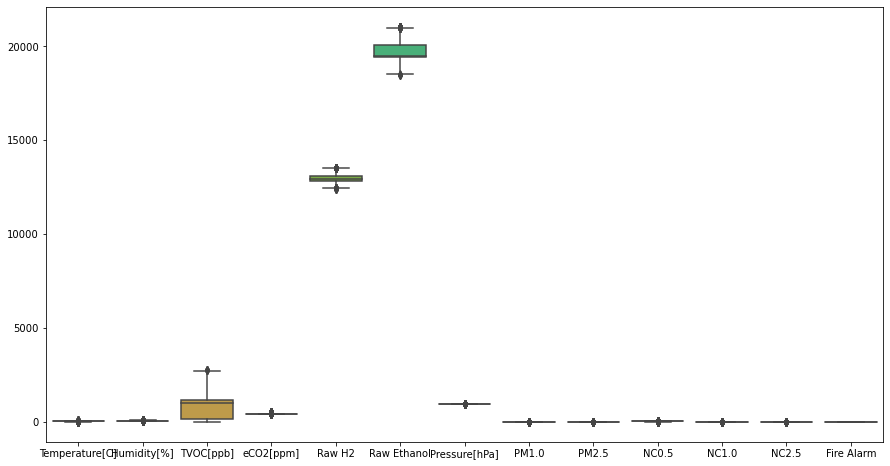

In [58]:
plt.figure(figsize=[15,8])
sns.boxplot(data=data)

## 1.LR

In [59]:
# change the name of columns
data['Humidity']=data['Humidity[%]']
data['Temperature']=data['Temperature[C]']
data['TVOC']=data['TVOC[ppb]']
data['ECO2']=data['eCO2[ppm]']
data['Pressure']=data['Pressure[hPa]']

In [60]:

# X = data[ [ 'Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]',
#        'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']]

X = data[ [ 'Temperature', 'Humidity', 'TVOC', 'ECO2',
       'Raw H2', 'Raw Ethanol', 'Pressure', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']]

y = data['Fire Alarm']

#Spliting data into Training 90%, Test set 10%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [61]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [62]:
# Make predictions using the testing set
y_pred = model.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))
r2 = r2_score(y_test,y_pred)
print('R^2 score on test set =',r2)

Mean squared error: 0.10
Coefficient of determination: 0.50
R^2 score on test set = 0.5028909629196263


In [63]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(y_train, X_train).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Fire Alarm   R-squared (uncentered):                   0.855
Model:                            OLS   Adj. R-squared (uncentered):              0.855
Method:                 Least Squares   F-statistic:                          2.771e+04
Date:                Sat, 03 Dec 2022   Prob (F-statistic):                        0.00
Time:                        21:54:59   Log-Likelihood:                         -16078.
No. Observations:               56367   AIC:                                  3.218e+04
Df Residuals:                   56355   BIC:                                  3.229e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    -0.0035   9.67e-05    -36.307      0.000      -0.004      -0.003
Humidity        0.0339      0.000     80.313      0.000       0.033       0.035
TVOC            0.0002   4.47e-06     46.128      0.000       0.000       0.000
ECO2            0.0005    9.1e-05      5.754      0.000       0.000       0.001
Raw H2          0.0006   9.71e-06     58.759      0.000       0.001       0.001
Raw Ethanol    -0.0003   5.32e-06    -51.660      0.000      -0.000      -0.000
Pressure       -0.0038      0.000    -20.149      0.000      -0.004      -0.003
PM1.0           0.1352      0.021      6.391      0.000       0.094       0.177
PM2.5           0.2964      0.048      6.195      0.000       0.203       0.390
NC0.5          -0.0203      0.003     -7.285      0.000      -0.026      -0.015
NC1.0          -0.1038      0.048     -2.166      0.030      -0.198      -0.010
NC2.5           0.2252      0.213      1.056      0.291      -0.193       0.643
==============================================================================
Omnibus:                     4767.652   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7309.703
Skew:                          -0.659   Prob(JB):                         0.00
Kurtosis:                       4.173   Cond. No.                     3.72e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.72e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Except **NC2.5** has the p-value 0.291, which is greater and hence it is a non significant feature, all other features are significant.
The coefficient of Temperature, Raw Ethanol, Pressure, NC0.5 and NC1.0 are negative which means they have a negative relationship with Fire Alarm, and all other coefficient are positive so their relationship with Fire Alarm is positive.


### SHAP

In [ ]:
shap.initjs()

In [64]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 6264it [00:48, 105.58it/s]                                                                      


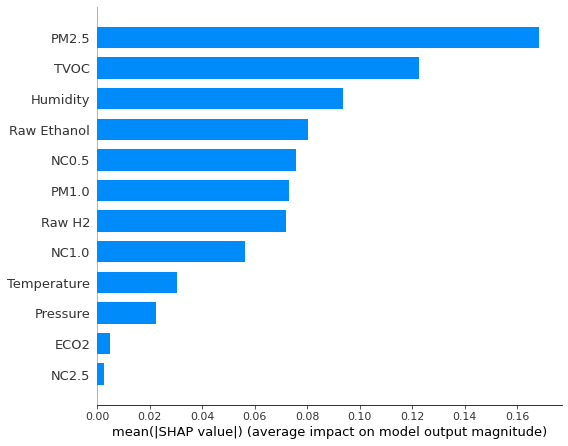

In [104]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar")

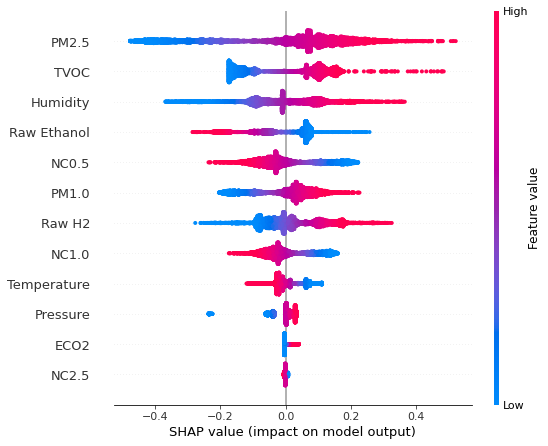

In [105]:
shap.summary_plot(shap_values, X_test)

1. From the two plots above, we can know that PM2.5 is the most effective feature in Linear Regression model, when it's value is larger than average, it drives the prediction to the right.

2. The second one is TVOC and third one is Humidty, they all work like PM2.5.

3. However, Raw Ethanol and NC0.5 work differently, when their value is smaller than the average, they dirve the prediction to the right.

### Partial Dependence Plots

In [67]:

def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            model.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature, 
            model.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

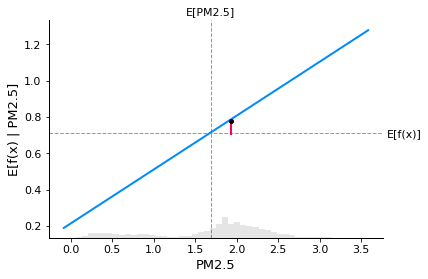

In [68]:
partial_dependence_plot('PM2.5', 0)

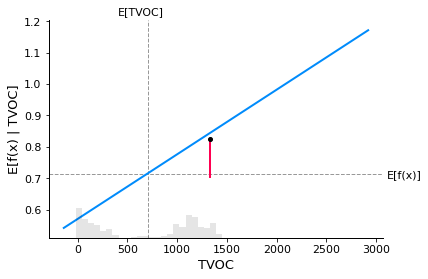

In [69]:
partial_dependence_plot('TVOC', 0)

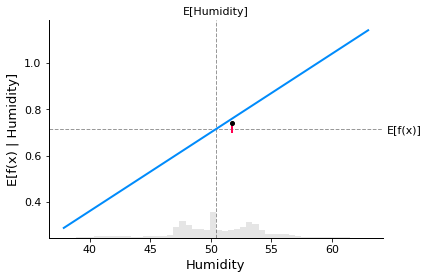

In [71]:
partial_dependence_plot('Humidity', 0)

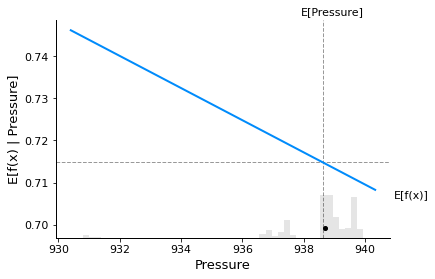

In [72]:
partial_dependence_plot('Pressure', 0)

The plots above are partial dependence plot which describe how every single feature affect the model. As you can see, there is a lot of features in our model, so it is cumbersome to plot every feature's partial dependence plot. Besides, it is hard to compare each features at the same time. Personally I prefer the SHAP method, and I won't provide PDP example for the next two models. 

## 2. Randomforest

In [106]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [63]:
# Make predictions using the testing set
y_pred = model.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))
r2 = r2_score(y_test,y_pred)
print('R^2 score on test set =',r2)

Mean squared error: 0.00
Coefficient of determination: 1.00
R^2 score on test set = 1.0


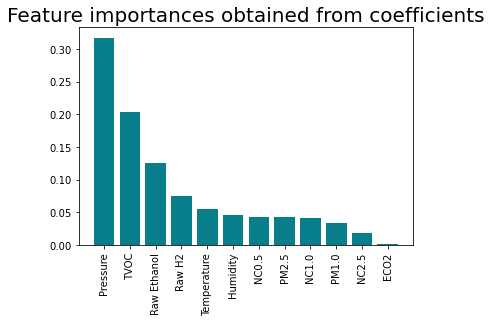

In [64]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### SHAP

In [107]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 6264it [36:39,  2.83it/s]                                                                       


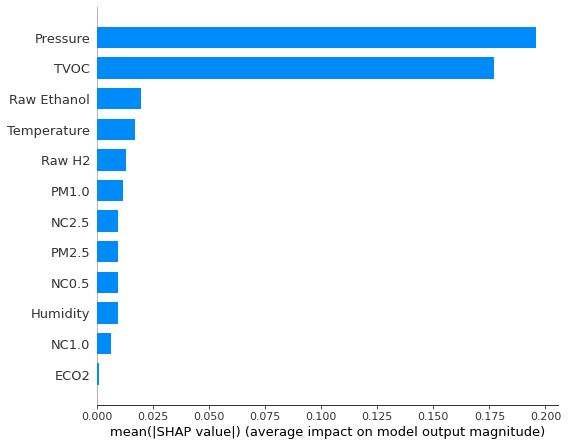

In [109]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar")

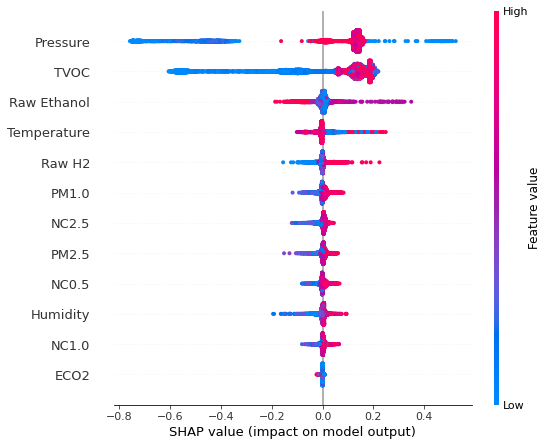

In [110]:
shap.summary_plot(shap_values, X_test)

1. From the two plots above, we can know that Pressure is the most effective feature in Random Forest model, when it's value is smaller than average, it drives the prediction to the left and right.

2. The second one is TVOC and third one is Raw Ethanol, the TVOC's value smaller than average driving the prediction to left and Raw Ethanol works the opposite.

3. Raw H2, PM1.0, NC2.5, PM2.5, NC0.5, Humidity and NC1.0 work similarly, the all drive the prediction to right when their values larger than average.

## 3.AutoML

In [10]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from D:\anaconda\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\85251\AppData\Local\Temp\tmpw6cn2xno
  JVM stdout: C:\Users\85251\AppData\Local\Temp\tmpw6cn2xno\h2o_85251_started_from_python.out
  JVM stderr: C:\Users\85251\AppData\Local\Temp\tmpw6cn2xno\h2o_85251_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,1 month and 6 days
H2O_cluster_name:,H2O_from_python_85251_tzrmwc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.511 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [11]:
data = h2o.H2OFrame(data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [12]:
data.head()

Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
20,57.36,0,400,12924,18520,939.735,1.81,1.88,12.45,1.943,0.044,0
20.015,56.67,0,400,12924,18651,939.744,1.81,1.88,12.45,1.943,0.044,0
20.029,55.96,0,400,12924,18764,939.738,1.81,1.88,12.45,1.943,0.044,0
20.044,55.28,0,400,12924,18849,939.736,1.81,1.88,12.45,1.943,0.044,0
20.059,54.69,0,400,12924,18921,939.744,1.81,1.88,12.45,1.943,0.044,0
20.073,54.12,0,400,12419,18998,939.725,1.81,1.88,12.45,1.943,0.044,0
20.088,53.61,0,400,12432,19058,939.738,1.81,1.88,12.45,1.943,0.044,0
20.103,53.2,0,400,12439,19114,939.758,1.81,1.88,12.45,1.943,0.044,0
20.117,52.81,0,400,12448,19155,939.758,1.81,1.88,12.45,1.943,0.044,0
20.132,52.46,0,400,12453,19195,939.756,0.9,1.88,12.45,1.943,0.044,0


In [13]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

In [14]:
# check the number of train set and test set
train["is_train"] = 1
test["is_train"] = 0

drift_data = train.rbind(test)
drift_data["is_train"] = drift_data["is_train"].asfactor()

In [15]:
drift_data["is_train"].table()

is_train,Count
0,15678
1,46952


In [16]:
x = list(set(train.col_names) - set(["Fire Alarm"]))

In [17]:
from h2o.automl import H2OAutoML
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "random_split")
aml.train(x=x, y="Fire Alarm", training_frame=train)

AutoML progress: |
20:56:52.838: AutoML: XGBoost is not available; skipping it.
20:56:52.869: _train param, Dropping bad and constant columns: [is_train]
20:56:52.869: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.


20:56:53.795: _train param, Dropping bad and constant columns: [is_train]
20:56:53.795: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

████████
20:57:39.662: _train param, Dropping bad and constant columns: [is_train]
20:57:39.662: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before 

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_1_20221203_205652


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    38                 38                          40124                  10           18           13.7368       49            128           79.6053

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.00018340857442812763
RMSE: 0.013542842184273124
MAE: 0.0007705409533922506
RMSLE: 0.009838228197703545
Mean Residual Deviance: 0.00018340857442812763

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.00019180557995548064
RMSE: 0.01384938915459742
MAE: 0.000956491053150102
RMSLE: 0.01007432168357405
Mean Residual Deviance: 0.00019180557995548064

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.000974503  5.78498e-05  0.000904742   0.00100832    0.000927963   0.00104581    0.000985676
mean_residual_deviance  0.000193411  4.77702e-05  0.000187169   0.000168951   0.000181618   0.000275686   0.000153631
mse                     0.000193411  4.77702e-05  0.000187169   0.000168951   0.000181618   0.000275686   0.000153631
r2                      0.999052     0.000234506  0.999082      0.999172      0.999109      0.998648      0.999247
residual_deviance       0.000193411  4.77702e-05  0.000187169   0.000168951   0.000181618   0.000275686   0.000153631
rmse                    0.0138308    0.00162734   0.013681      0.0129981     0.0134766     0.0166038     0.0123948
rmsle                   0.0100817    0.00102199   0.0100785     0.00911254    0.00976819    0.0118002     0.00964913

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2022-12-03 20:57:43  3.527 sec   0                  nan              nan             nan
    2022-12-03 20:57:43  3.625 sec   5                  0.0230437        0.000790132     0.000531013
    2022-12-03 20:57:43  3.724 sec   10                 0.0181472        0.000734947     0.000329319
    2022-12-03 20:57:43  3.773 sec   15                 0.0153891        0.000708566     0.000236824
    2022-12-03 20:57:43  3.820 sec   20                 0.0146444        0.000727042     0.000214458
    2022-12-03 20:57:43  3.864 sec   25                 0.0138138        0.000730916     0.000190822
    2022-12-03 20:57:43  3.905 sec   30                 0.0135449        0.000732495     0.000183465
    2022-12-03 20:57:43  3.946 sec   35                 0.0134532        0.000761456     0.000180987
    2022-12-03 20:57:43  3.973 sec   38                 0.0135428        0.000770541     0.000183409

Variable Importances: 
variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
Pressure[hPa]   123313                 1                    0.437494
TVOC[ppb]       75274                  0.610431             0.26706
Raw Ethanol     13999.8                0.113531             0.049669
Humidity[%]     12363.2                0.100259             0.0438627
Raw H2          12210.9                0.0990241            0.0433224
Temperature[C]  11417.5                0.0925896            0.0405074
PM2.5           10322                  0.0837053            0.0366205
NC0.5           9051.52                0.0734028            0.0321133
NC1.0

In [18]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head() 

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
DRF_1_AutoML_1_20221203_205652,0.000956491,0.0138494,0.000191806,0.0100743,0.000191806
XRT_1_AutoML_1_20221203_205652,0.00106323,0.014715,0.000216531,0.0107024,0.000216531
StackedEnsemble_BestOfFamily_1_AutoML_1_20221203_205652,0.00140672,0.0137874,0.000190091,0.0100139,0.000190091
StackedEnsemble_AllModels_1_AutoML_1_20221203_205652,0.00186782,0.0135053,0.000182392,0.00985745,0.000182392
GBM_grid_1_AutoML_1_20221203_205652_model_1,0.00234044,0.0155651,0.000242273,0.0113415,0.000242273
GBM_4_AutoML_1_20221203_205652,0.00280663,0.0141114,0.000199133,0.0104092,0.000199133
GBM_2_AutoML_1_20221203_205652,0.00305216,0.0152828,0.000233564,0.011466,0.000233564
GBM_5_AutoML_1_20221203_205652,0.00308671,0.0154836,0.000239741,0.0112529,0.000239741
GBM_3_AutoML_1_20221203_205652,0.00325283,0.015317,0.000234611,0.0113464,0.000234611
GBM_1_AutoML_1_20221203_205652,0.00445604,0.0181149,0.000328148,0.0132561,0.000328148


In [19]:
best_model = aml.leader
best_model.model_performance(test)

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 8.237248538271718e-05
RMSE: 0.009075928899166034
MAE: 0.000669168775936327
RMSLE: 0.006347338610327737
Mean Residual Deviance: 8.237248538271718e-05

### SHAP

In [20]:
# Help function
class H2OProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(h2o.H2OFrame(self.dataframe)).as_data_frame().values
        return self.predictions.astype('float64')[:,-1] #probability of True class


In [ ]:
#Reading dataset
data = pd.read_csv("C:\\Users\\85251\\Desktop\\6105\\a1\\smoke_detection_iot.csv", index_col=0)

In [ ]:

X = data[ [ 'Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]',
       'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']]
y = data['Fire Alarm']

#Spliting data into Training 90%, Test set 10%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [22]:
feature_names = list(X_train.columns)
h2o_wrapper = H2OProbWrapper(best_model,feature_names) 

In [32]:
explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob,X_train[:50])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [45]:
shap_values = explainer.shap_values(X_test[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

Due to Memory Error of my computer, I can only excute 50 data at a time, and it's already the best situation, usually my computer crash when it comes to 30

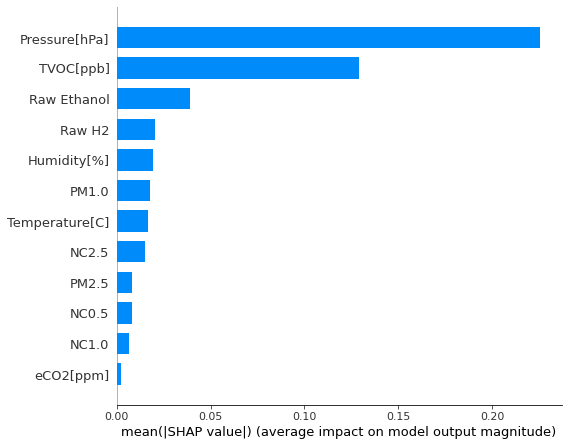

In [46]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

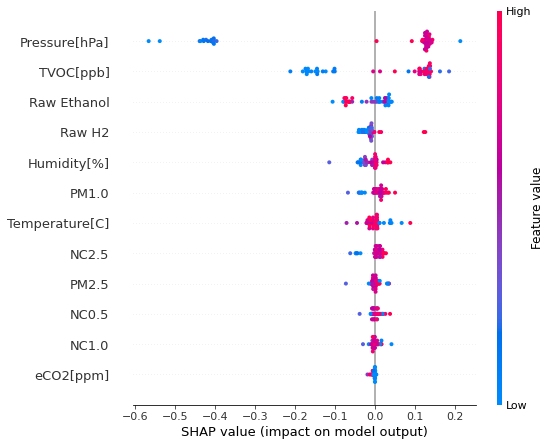

In [47]:
shap.summary_plot(shap_values, X_test[:50])

1. From the two plots above, we can know that Pressure is the most effective feature in Random Forest model, when it's value is larger than average, it drives the prediction to the right.

2. The second one is TVOC and third one is Raw Ethanol, the TVOC works as Pressure, however, Raw Ethanol works the opposite.

3. Raw H2, Humidity PM1.0, NC2.5, NC0.5 work similarly, they all drive the prediction to right when their values larger than average. And the Temperature, PM2.5 and NC1.0 work the opposite.

### Refernces

1. W3schools
2. Generate 'n' unique random numbers within a range
3. A Complete Guide to Dealing with Missing values in Python
4. Smoke Detection Preprocessing


Copyright (c) 2022 Chenxu Zhao

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
